Hi, this notebook is aimed to show the power of one-hot encoding in classification models. Instead of dumping all kinds of variables into one classification model, carefully chosen categorical variables are much more effective while building classification models. Not just converting ordinal and nominal variables into binary variables, but also converting numerical and continous variables into binary variables by carefully chosen thresholds can help a lot for the model to grasp the trends in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Importing datasets
train = pd.read_csv("/kaggle/input/titanic/train.csv")

test = pd.read_csv("/kaggle/input/titanic/test.csv")

gender_submission = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

## 1. Data Exploration and Data Cleaning/Filling

In [3]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

There are 177 empty records in Age column, which seems to be an important feature.

In [6]:
train.corr(numeric_only=True)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


It is seen that age variable is very correlated with Pclass. So, in order to fill out the empty age values, we can take advantage of this feature. We can fill out the empty age values with the average age for the corresponding Pclass subset.

In [7]:
# Defining the dictionary for 3 different Pclasses to keep the average ages
Class_to_Age = train[~train["Age"].isna()].groupby("Pclass")["Age"].agg(lambda x: np.mean(x)).to_dict()

In [8]:
Class_to_Age

{1: 38.233440860215055, 2: 29.87763005780347, 3: 25.14061971830986}

In [9]:
#Filling the empty ages with the average values obtained from Class_to_Age
train.fillna(0,inplace =True)

train["Age"] = train.apply(lambda x: x if x["Age"] != 0 else Class_to_Age[x["Pclass"]],axis = 1)["Age"]

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S


Before converting everything into binary variables, one might think that instead of converting all variables into different columns with one-hot-encoding, why don't we combine some variables into one group. For example instead of adding 7 features for different kinds of Patch, why don't we convert it into two features as one feature indicating "Is Patch number equal to 0" and other feature indicating "Is Patch number greater than 0". Let's analyze this.

In [11]:
# Defining the function to calculate the ratio of survivors for different groups of Parch and SibSp
def calc_rate(group):
    num_ones = group['Survived'][group['Survived'] == 1].size
    denom = group['Survived'].size
    return num_ones / denom


In [12]:
train.groupby('Parch').apply(calc_rate).to_frame("Survival Rate").reset_index()

,Parch,Survival Rate
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


In [13]:
train.groupby('SibSp').apply(calc_rate).to_frame("Survival Rate").reset_index()

,SibSp,Survival Rate
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


As you see, different Patch and SibSp numbers have different Survival rates. So, if we were to combine some categories with each other, we would lose some information. That is why it is better to keep all.

## 2. One-hot Encoding

In [14]:
# Seperating target variables and features
X = train.drop(["PassengerId","Survived","Name","Ticket","Fare","Cabin","Embarked"],axis =1)

y = train["Survived"]

In [15]:
# Converting all discrete variables except for Age into binary variables
df = pd.get_dummies(X, columns = ['Pclass', 'Sex','SibSp','Parch'])
df

,Age,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,22.00000,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,38.00000,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,26.00000,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,35.00000,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,35.00000,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.00000,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
887,19.00000,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
888,25.14062,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
889,26.00000,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0


How do we convert Age into binary variables?

Let's find out the distribution of Age.

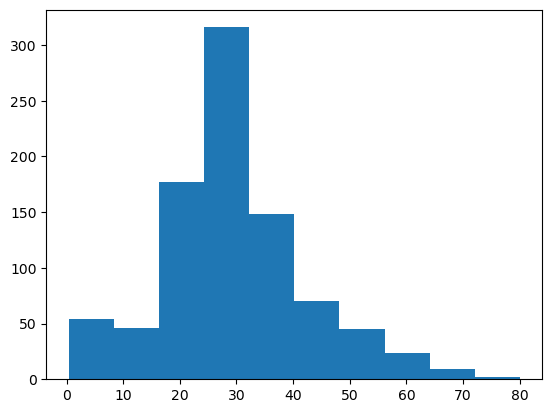

In [16]:
# Histogram of Age
plt.hist(train["Age"], bins=10)
plt.show()

It looks like the distribution is like gaussion distribution. 
Let's apply Kmeans algorithm to the Age column to find the optimal thresholds to construct binary variables by splitting by thresholds.

The silhouette score ranges from -1 to 1, with higher values indicating better clustering quality

In [17]:
# Trying different options for n_clusters to find the optimal one.
Ages = np.array(train["Age"]).reshape(-1,1)
cluster_list = [2,3,4,5]
for i in cluster_list:
    kmeans = KMeans(n_clusters = i,random_state = 0,n_init=10)
    kmeans.fit(Ages)
    labels = kmeans.predict(Ages)
    silhouette = silhouette_score(Ages, labels)
    print("Silhouette score for {}:".format(i), silhouette)

    

Silhouette score for 2: 0.5939011646748926
Silhouette score for 3: 0.5320513635752335
Silhouette score for 4: 0.5926613214757969
Silhouette score for 5: 0.5888009485324679


By looking at the scores, it seems that 4 is a good choice.

In [18]:
optimal_k = 4  
kmeans = KMeans(n_clusters=optimal_k, random_state=0,n_init=10)
kmeans.fit(Ages)

KMeans(n_clusters=4, n_init=10, random_state=0)

In [19]:
# Obtaining the centroids for the clusters.
final_labels = kmeans.labels_
centroids = kmeans.cluster_centers_
centroids.ravel().sort()
centroids = centroids.ravel()

In [20]:
centroids

array([ 6.36951807, 23.9837436 , 37.3276733 , 55.17346939])

In [21]:
# Defining the function to be applied on df to convert Age features into binary variables with certain thresholds.
def assign_groups(x):
    if x < centroids[0]:
        return 1
    elif x >= centroids[0] and x < centroids[1]:
        return 2
    elif x >= centroids[1] and x < centroids[2]:
        return 3
    elif x >= centroids[2] and x < centroids[3]:
        return 4
    else:
        return 5

In [22]:
# Converting Age column into binary variables
df = df.assign(Age_group=df['Age'].apply(lambda x: assign_groups(x)))

df = pd.get_dummies(df, columns = ['Age_group'])

df.drop("Age",inplace = True,axis = 1)


In [23]:
df.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,...,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Age_group_1,Age_group_2,Age_group_3,Age_group_4,Age_group_5
0,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


So, as seen, all variables were converted into binary variables.

## 3. Modeling

In [24]:
# Building a simple RandomForest Model on train set.
X_train, X_test, y_train, y_test = train_test_split( 
df, y, test_size=0.3, random_state=42)

rfc = RandomForestClassifier(n_estimators=100, random_state=42)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

accuracy

0.8134328358208955

Finally, we obtained accuracy for test set like this. This work shows how valuable one-hot encoding might be while tackling with the data for classification model.